In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#pytorch libraries
import torch
from torch import nn, optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F

#Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
#Sklearn train teste split and report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim import lr_scheduler
#
import copy
import os

In [14]:
class configFile():
    batch_size = 128
    val_size = 0.1
    learning_rate = 1e-3

cfg = configFile()

In [5]:
train_df = pd.read_csv('./train.csv', dtype=np.float32)
test_df = pd.read_csv('./test.csv', dtype=np.float32)

In [13]:
# def prepData(data, label, train_val = True):
#     if train_val:
#         X = data.drop(label, axis = 1).values/225 
#         X = X.reshape((-1,1,28,28))
#         X = torch.from_numpy(X) # to tensor
#         y = data[label].values
#         y = torch.from_numpy(y).type(torch.LongTensor) # to tensor
#         return X, y
#     else:
#         X = data.values/225
#         X = X.reshape((-1,1,28,28))
#         X = torch.from_numpy(X)
#         return X 
    
# X_tensor, y_tensor = prepData(train_df, label = 'label', train_val = True)
# X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor,
#                                                   test_size = cfg.val_size,
#                                                   random_state = 12,
#                                                   stratify = y_tensor)

In [67]:
# 由于torch版本问题？需要先split，再转成tensor，跟原作的顺序不一样

In [57]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop('label',axis=1),
    train_df['label'],
    test_size = cfg.val_size,
    random_state = 12,
    stratify = y_tensor)

In [54]:
def prepTensor(if_x=None, data=None):
    if if_x:
        X = data.values/225
        X = X.reshape((-1,1,28,28))
        X = torch.from_numpy(X) # to tensor
        return X
    elif if_x == False:
        y = data.values
        y = torch.from_numpy(y).type(torch.LongTensor)
        return y

In [61]:
X_train = prepTensor(if_x=True, data=X_train)
X_val = prepTensor(if_x=True, data=X_val)

In [59]:
y_train = prepTensor(if_x=False, data=y_train)
y_val = prepTensor(if_x=False, data=y_val)

In [143]:
len(train)

37800

In [62]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)

In [70]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size  = cfg.batch_size, 
                                           shuffle = True)
val_loader = torch.utils.data.DataLoader(val,
                                           batch_size  = cfg.batch_size, 
                                           shuffle = True)

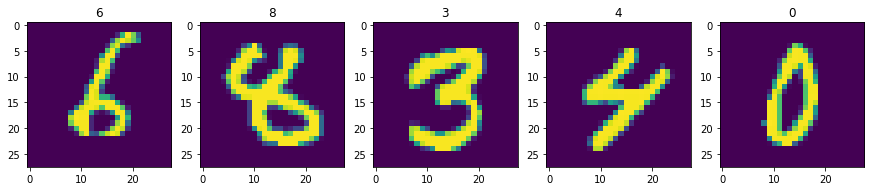

In [100]:
#Number of images to show
images_to_show = 5
#Create a subplot figure
fig, ax = plt.subplots(nrows = 1, ncols = 5,  figsize = (15,8))
for i, (X,y) in enumerate(train_loader): # iterata over train_loader
#     print(i)
    image = X[i]
#     print(image)
    ax[i].imshow(image.squeeze(), cmap="viridis") # Squeeze removes length (1,28,28) -> (28,28)
    ax[i].set_title(int(y[i])) # set a title
    if i == (images_to_show -1): break # end iteration if reached max of images to show

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [119]:
class ConvNet(nn.Module):
    """Class to build the Convolutional network"""
    def __init__(self):
        super(ConvNet,self).__init__()
        #1 Conv layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=64,#32,
                               kernel_size=5) 
        # shape: (28-5+1)*(28-5+1)*32=24*24*32
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # shape: (24/2)*(24/2)*32=12*12*32
        #2 Conv layers
        self.conv2 = nn.Conv2d(in_channels=64,#32,
                               out_channels=128,#64,
                               kernel_size=5)
        # shape: (12-5+1)*(12-5+1)*64=8*8*64
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # shape: (8/2)*(8/2)*64=4*4*64=1024
        # Flatten layers
        self.flatten = nn.Flatten()
#         self.linear1 = nn.Linear(in_features=1024, out_features=160)
#         self.linear2 = nn.Linear(in_features=160, out_features=92)
#         self.linear3 = nn.Linear(in_features=92, out_features=10)
        
        self.linear1 = nn.Linear(in_features=1024*2, out_features=200*2)
        self.linear2 = nn.Linear(in_features=400, out_features=200)
        self.linear3 = nn.Linear(in_features=200, out_features=100)
        self.linear4 = nn.Linear(in_features=100, out_features=10)
        
    def forward(self, x):
        """Forward Method"""
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.linear4(out)
        
        return out

In [120]:
def train_(model, optimizer, loss_func, train_loader, device):
    """Function to train the model"""
    train_loss = 0.0
    train_correct = 0
    size_sampler = len(train_loader.sampler) # ??
    
    for i, (images, labels) in enumerate(train_loader):
        # push the data to device
        images, labels = images.to(device), labels.to(device)
        #  zeroing the optimizer
        optimizer.zero_grad()
        # feed foward
        y_hat = model(images)
        # compute loss
        loss = loss_func(y_hat, labels)
        # compute backpropagation
        loss.backward()
        # updating the weights
        optimizer.step()
        # loss and correct values compute
        train_loss += loss.item() * images.size(0)
        _, pred = torch.max(y_hat.data, 1)
        train_correct += sum(pred==labels).sum().item()
    return np.round(train_loss / size_sampler, 
                    4),np.round(train_correct*100./size_sampler, 3)

def validation_(model, loss_func, val_loader, device):
    val_loss = 0.0
    val_correct = 0
    size_sampler = len(val_loader.sampler)
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            y_hat = model(images)
            loss = loss_func(y_hat, labels)
            
            val_loss += loss.item() * images.size(0)
            _, pred = torch.max(y_hat.data, 1)
            val_correct += (pred==labels).sum().item()
    return np.round(val_loss/size_sampler,
                    4), np.round(val_correct*100./size_sampler,3)

def train_model(model, optimizer, loss_func, scheduler, train_loader,
               val_loader, epochs, device, log=True):
    best_acc = 0
    print("Initializing Training...")
    history = {'train_loss':[], 'val_loss':[],
               'train_acc':[], 'val_acc':[]}
    for i in range(epochs):
        train_loss, train_acc = train_(model, optimizer, loss_func,
                                       train_loader, device)
        val_loss, val_acc = validation_(model, loss_func,
                                        val_loader, device)
        scheduler.step() #???
        if val_acc > best_acc:
            print(f'>> Saving best model with val acc:old:{best_acc}|new:{val_acc}')
            best_model = copy.deepcopy(model)
            best_acc = val_acc
        if log and ((i+1)%2==0):
            print(f'> Epochs: {i+1}/{epochs} - Train loss:{train_loss} - Train acc:{train_acc} - Val Loss:{val_loss} - Val Acc:{val_acc}')
        for key, value in zip(history, [train_loss,val_loss,train_acc,val_acc]):
            history[key].append(value)
        print('...End Training')
    return history, best_model

In [121]:
def plot_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    # loss
    sns.lineplot(data = history['train_loss'],
                 label='training loss',
                 ax = ax[0])
    sns.lineplot(data = history['val_loss'],
                 label = 'validation loss',
                 ax = ax[0])
    ax[0].legend(loc='upper right')
    ax[0].set_title('loss')
    # accuracy
    sns.lineplot(data = history['train_acc'],
                 label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history['val_acc'],
                 label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title('Accuracy')

In [122]:
model = ConvNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr = cfg.learning_rate)
loss_func = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.05)

history, best_model = train_model(model=model,
                                  optimizer = optimizer,
                                  loss_func = loss_func,
                                  scheduler = scheduler,
                                  train_loader = train_loader,
                                  val_loader = val_loader,
                                  epochs = 50,
                                  device = device)

Initializing Training...
>> Saving best model with val acc:old:0|new:97.19
...End Training
>> Saving best model with val acc:old:97.19|new:98.119
> Epochs: 2/50 - Train loss:0.0495 - Train acc:98.413 - Val Loss:0.0797 - Val Acc:98.119
...End Training
...End Training
>> Saving best model with val acc:old:98.119|new:98.595
> Epochs: 4/50 - Train loss:0.0248 - Train acc:99.233 - Val Loss:0.0614 - Val Acc:98.595
...End Training
>> Saving best model with val acc:old:98.595|new:98.714
...End Training
> Epochs: 6/50 - Train loss:0.0153 - Train acc:99.505 - Val Loss:0.0685 - Val Acc:98.524
...End Training
...End Training
> Epochs: 8/50 - Train loss:0.0123 - Train acc:99.577 - Val Loss:0.0939 - Val Acc:98.524
...End Training
...End Training
>> Saving best model with val acc:old:98.714|new:98.905
> Epochs: 10/50 - Train loss:0.005 - Train acc:99.817 - Val Loss:0.0525 - Val Acc:98.905
...End Training
...End Training
>> Saving best model with val acc:old:98.905|new:98.929
> Epochs: 12/50 - Train l

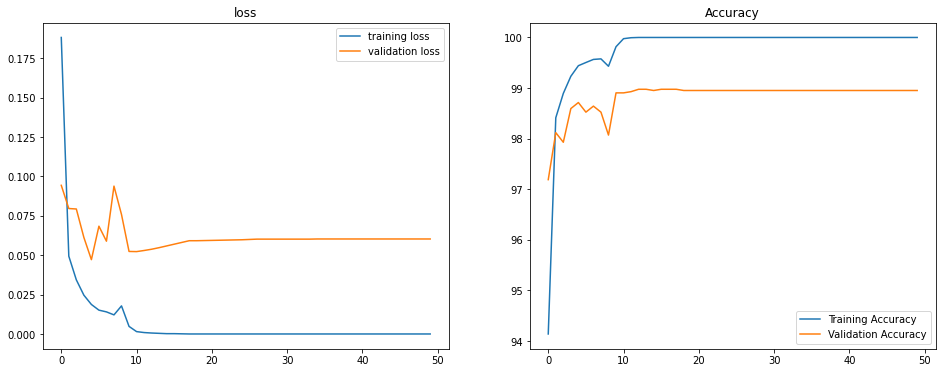

In [123]:
plot_history(history)

In [127]:
X_test = prepTensor(if_x=True, data=test_df)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1,
                                          shuffle=False)
y_pred_list = []
with torch.no_grad():
    for X_test_1d in (test_loader):
        y_pred = best_model(X_test_1d.to(device))
        _, y_pred_tags = torch.max(y_pred, dim=1)
        y_pred_list.append(y_pred_tags.to('cpu'))

result = [int(i[0]) for i in y_pred_list]
df = pd.Series(result, name='Label').reset_index()
df.rename(columns = {'index': 'ImageId'}, inplace=True)
df['ImageId'] = df['ImageId'] + 1
df.to_csv('submisstion_v1.csv',index=False)

0
1
2
3
4
5
6
7
8
9


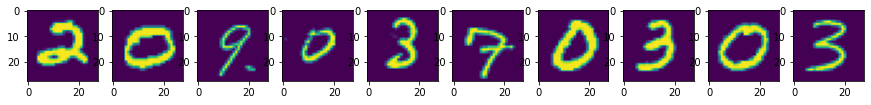

In [141]:
#Visualizing some examples in the training dataset X

#Number of images to show
images_to_show = 10
#Create a subplot figure
fig, ax = plt.subplots(nrows = 1, ncols = 10,  figsize = (15,8))
for i, X in enumerate(test_loader): # iterata over train_loader
    print(i)
    image = X
#     print(image)
    ax[i].imshow(image.squeeze(), cmap="viridis") # Squeeze removes length (1,28,28) -> (28,28)
#     ax[i].set_title(int(y[i])) # set a title
    if i == (images_to_show -1): break # end iteration if reached max of images to show

In [135]:
len(test_loader)

28000

In [142]:
df[0:10]

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
